In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay, make_scorer, f1_score
from sklearn.inspection import permutation_importance
import joblib

In [2]:
df = pd.read_csv("C:/Users/User/Downloads/synthetic_asthma_dataset.csv")

In [3]:
df.shape

(10000, 17)

In [4]:
df.head()

,Patient_ID,Age,Gender,BMI,Smoking_Status,Family_History,Allergies,Air_Pollution_Level,Physical_Activity_Level,Occupation_Type,Comorbidities,Medication_Adherence,Number_of_ER_Visits,Peak_Expiratory_Flow,FeNO_Level,Has_Asthma,Asthma_Control_Level
0,ASTH100000,52,Female,27.6,Former,1,NaN,Moderate,Sedentary,Outdoor,Diabetes,0.38,0,421.0,46.0,0,NaN
1,ASTH100001,15,Male,24.6,Former,0,Dust,Low,Moderate,Indoor,Both,0.60,2,297.6,22.9,0,NaN
2,ASTH100002,72,Female,17.6,Never,0,NaN,Moderate,Moderate,Indoor,NaN,0.38,0,303.3,15.3,0,NaN
3,ASTH100003,61,Male,16.8,Never,0,Multiple,High,Sedentary,Outdoor,Both,0.60,1,438.0,40.1,1,Poorly Controlled
4,ASTH100004,21,Male,30.2,Never,0,NaN,Moderate,Active,Indoor,NaN,0.82,3,535.0,27.7,0,NaN


In [5]:
df.columns

Index(['Patient_ID', 'Age', 'Gender', 'BMI', 'Smoking_Status',
       'Family_History', 'Allergies', 'Air_Pollution_Level',
       'Physical_Activity_Level', 'Occupation_Type', 'Comorbidities',
       'Medication_Adherence', 'Number_of_ER_Visits', 'Peak_Expiratory_Flow',
       'FeNO_Level', 'Has_Asthma', 'Asthma_Control_Level'],
      dtype='object')

In [6]:
df = df.drop_duplicates()

In [7]:
df.shape

(10000, 17)

In [8]:
df.isnull().sum()

Patient_ID                    0
Age                           0
Gender                        0
BMI                           0
Smoking_Status                0
Family_History                0
Allergies                  2936
Air_Pollution_Level           0
Physical_Activity_Level       0
Occupation_Type               0
Comorbidities              4967
Medication_Adherence          0
Number_of_ER_Visits           0
Peak_Expiratory_Flow          0
FeNO_Level                    0
Has_Asthma                    0
Asthma_Control_Level       7567
dtype: int64

In [9]:
cols_with_nan = ['Allergies', 'Comorbidities', 'Asthma_Control_Level']
for col in cols_with_nan:
    df[col] = df[col].fillna("Unknown")

In [10]:
TARGET = "Has_Asthma"  
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(pd.Series(y_train).value_counts(normalize=True))

Has_Asthma
0    0.75675
1    0.24325
Name: proportion, dtype: float64


In [11]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['Age', 'BMI', 'Family_History', 'Medication_Adherence', 'Number_of_ER_Visits', 'Peak_Expiratory_Flow', 'FeNO_Level']
Categorical columns: ['Patient_ID', 'Gender', 'Smoking_Status', 'Allergies', 'Air_Pollution_Level', 'Physical_Activity_Level', 'Occupation_Type', 'Comorbidities', 'Asthma_Control_Level']


In [12]:
numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])
categorical_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
preprocess = ColumnTransformer([("num", numeric_pipe, numeric_cols),("cat", categorical_pipe, categorical_cols)])

In [13]:
df

,Patient_ID,Age,Gender,BMI,Smoking_Status,Family_History,Allergies,Air_Pollution_Level,Physical_Activity_Level,Occupation_Type,Comorbidities,Medication_Adherence,Number_of_ER_Visits,Peak_Expiratory_Flow,FeNO_Level,Has_Asthma,Asthma_Control_Level
0,ASTH100000,52,Female,27.6,Former,1,Unknown,Moderate,Sedentary,Outdoor,Diabetes,0.38,0,421.0,46.0,0,Unknown
1,ASTH100001,15,Male,24.6,Former,0,Dust,Low,Moderate,Indoor,Both,0.60,2,297.6,22.9,0,Unknown
2,ASTH100002,72,Female,17.6,Never,0,Unknown,Moderate,Moderate,Indoor,Unknown,0.38,0,303.3,15.3,0,Unknown
3,ASTH100003,61,Male,16.8,Never,0,Multiple,High,Sedentary,Outdoor,Both,0.60,1,438.0,40.1,1,Poorly Controlled
4,ASTH100004,21,Male,30.2,Never,0,Unknown,Moderate,Active,Indoor,Unknown,0.82,3,535.0,27.7,0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ASTH109995,70,Male,25.0,Never,0,Unknown,Low,Sedentary,Indoor,Unknown,0.67,0,580.6,18.7,0,Unknown
9996,ASTH109996,78,Female,24.8,Never,0,Pollen,Low,Moderate,Indoor,Diabetes,0.72,1,417.6,40.8,0,Unknown
9997,ASTH109997,58,Male,30.1,Former,1,Pollen,Low,Moderate,Indoor,Unknown,0.28,0,459.1,20.3,1,Not Controlled
9998,ASTH109998,88,Female,31.2,Former,0,Pollen,Moderate,Moderate,Indoor,Unknown,0.44,0,415.9,25.0,0,Unknown


In [14]:
log_reg = Pipeline([("prep", preprocess),("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
rf = Pipeline([("prep", preprocess),("clf", RandomForestClassifier(n_estimators=400, min_samples_split=4, min_samples_leaf=2,class_weight="balanced", random_state=42))])

In [21]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def compute_cv_f1(model, X, y, cv):
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    return scores.mean(), scores.std()
log_mean_f1, log_std_f1 = compute_cv_f1(log_reg, X_train, y_train, cv)
rf_mean_f1, rf_std_f1 = compute_cv_f1(rf, X_train, y_train, cv)
print(f"Logistic Regression F1-score: {log_mean_f1:.3f} ± {log_std_f1:.3f}")
print(f"Random Forest F1-score      : {rf_mean_f1:.3f} ± {rf_std_f1:.3f}")
#Selecting the best model
best_model = rf if rf_mean_f1 >= log_mean_f1 else log_reg
selected_model_name = "Random Forest" if best_model == rf else "Logistic Regression"
print("Selected model based on F1-score:", selected_model_name)

Logistic Regression F1-score: 1.000 ± 0.000
Random Forest F1-score      : 1.000 ± 0.000
Selected model based on F1-score: Random Forest


In [22]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1513
           1       1.00      1.00      1.00       487

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

[[1513    0]
 [   0  487]]


Top 20 features by importance:


,Feature,Importance_Mean,Importance_STD
15,Asthma_Control_Level,0.25270,0.003132
7,Air_Pollution_Level,0.01505,0.002006
5,Family_History,0.01305,0.001457
8,Physical_Activity_Level,0.00680,0.001833
4,Smoking_Status,0.00295,0.000723
6,Allergies,0.00295,0.000986
3,BMI,0.00000,0.000000
2,Gender,0.00000,0.000000
0,Patient_ID,0.00000,0.000000
1,Age,0.00000,0.000000


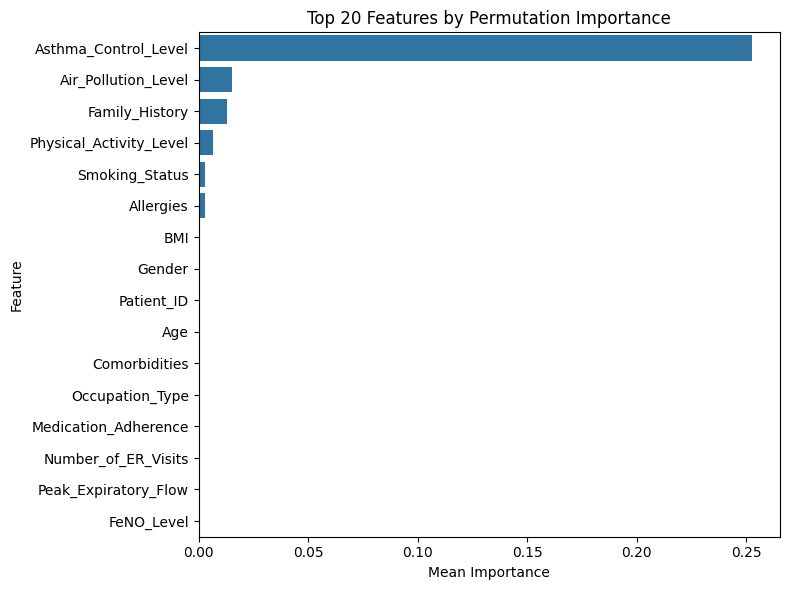

In [23]:
preprocess.fit(X_train, y_train)
from sklearn.inspection import permutation_importance
result = permutation_importance(best_model,X_test,y_test,n_repeats=10)
importances = pd.DataFrame({"Feature": X_train.columns,"Importance_Mean": result.importances_mean,"Importance_STD": result.importances_std})
importances = importances.sort_values("Importance_Mean", ascending=False)
print("Top 20 features by importance:")
display(importances.head(20))
plt.figure(figsize=(8,6))
sns.barplot(x="Importance_Mean",y="Feature",data=importances.head(20))
plt.title("Top 20 Features by Permutation Importance")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [18]:
# Save the trained model to a file so we can use it later without retraining
joblib.dump(best_model, "asthma_model.joblib")

['asthma_model.joblib']